In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Input

In [12]:
# Paths to datasets
train_path = 'Train'
validation_path = 'Validation'
test_path = 'Test'

In [13]:
# Image dimensions
img_height = 180
img_width = 180
batch_size = 32

In [14]:
# Load training, validation, and testing datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)


Found 200 files belonging to 5 classes.
Found 200 files belonging to 5 classes.
Found 200 files belonging to 5 classes.


In [15]:
# Class names
class_names = train_ds.class_names
print("Detected classes:", class_names)

Detected classes: ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']


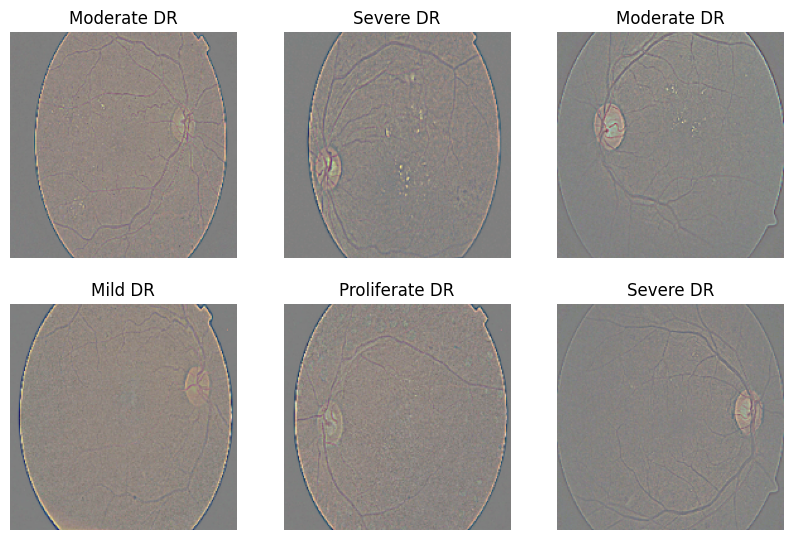

In [16]:
# Visualization of sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [17]:
# Normalize and cache datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [18]:
# Model architecture
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

In [19]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# Model training
epochs = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1972 - loss: 1.7393 - val_accuracy: 0.3550 - val_loss: 1.5925
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.2777 - loss: 1.5882 - val_accuracy: 0.4400 - val_loss: 1.5201
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4277 - loss: 1.4894 - val_accuracy: 0.3600 - val_loss: 1.3429
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4561 - loss: 1.2807 - val_accuracy: 0.5300 - val_loss: 1.1878
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4810 - loss: 1.2318 - val_accuracy: 0.5500 - val_loss: 1.1148
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5518 - loss: 1.0920 - val_accuracy: 0.5450 - val_loss: 1.0672
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5441 - loss: 1.1429 - val_accuracy: 0.5950 - val_loss: 1.0181
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6093 - loss: 0.9922 - val_accuracy: 0.6050 - val_loss: 0.9948
Epoch 9/

In [21]:
# Visualize training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


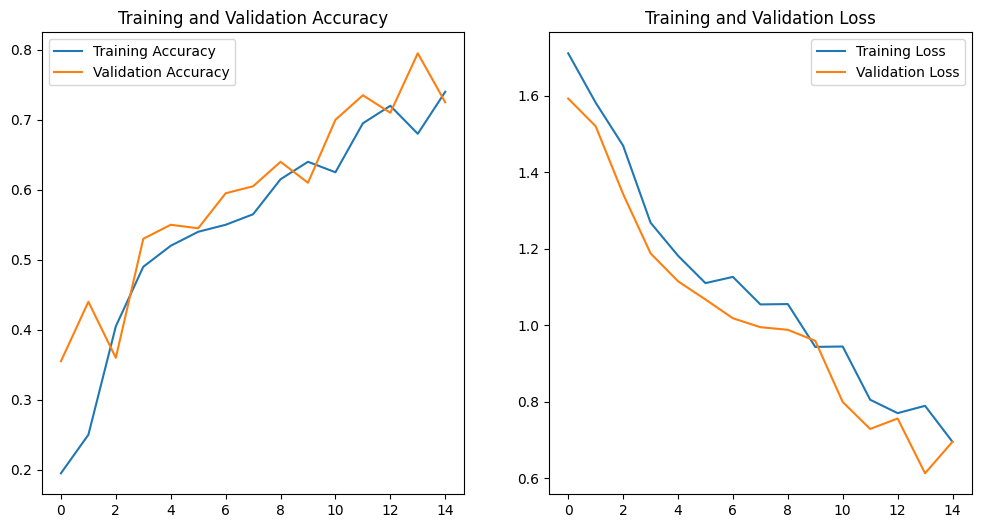

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


In [23]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step - accuracy: 0.7829 - loss: 0.5723
Test Accuracy: 0.73


In [26]:
# Prediction example
def predict_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(f"This image likely belongs to {class_names[np.argmax(score)]} with a accuracy of {100 * np.max(score):.2f}%.")

predict_image('Proliferate DR_26.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
This image likely belongs to Proliferate DR with a accuracy of 38.90%.


In [27]:
# Save the model
model.save('DR_Detection_Model.keras')